In [31]:
%matplotlib inline
import numpy as np
import lib.io.stan
import lib.plots.stan
import matplotlib.pyplot as plt
import os
from matplotlib.lines import Line2D
import retro_prepare
import matplotlib.colors
import glob

In [34]:
import mne
import pandas as pd
import re

In [32]:
import json
with open(f'../ANSM/util/data/ei-vep.json','r') as f:
        ezh_all = json.load(f)

In [36]:
import matplotlib.gridspec as gridspec

In [35]:
def read_vep_mrtrix_lut():
    roi_names = []
    with open('../ANSM/util/data/VepMrtrixLut.txt', 'r') as fd:
        for line in fd.readlines():
            i, roi_name, *_ = line.strip().split()
            roi_names.append(roi_name)
            #roi_name_to_index[roi_name.lower()] = int(i) - 1
    return roi_names
roi = read_vep_mrtrix_lut()
roi=roi[1:]

In [37]:
def find_ez(onst_thrshld=0.0, csv_path='', save_dir=''):
    import numpy as np
    import lib.io.stan
    import os

    optima = lib.io.stan.read_samples([csv_path])
    x = optima['x'][0]
    nn = x.shape[1]
    onsets = 200*np.ones(nn)
    for i in range(nn):
        xt = x[:,i] > onst_thrshld
        if(xt.any()):
            onsets[i] = np.where(x[:,i] > onst_thrshld)[0][0]
    a, b = np.histogram(onsets[onsets<150])
    ez_pred = np.zeros(nn)
    ez_pred[np.where(onsets<b[1])] = 1
    np.save(os.path.join(save_dir, 'ez_pred.npy'), ez_pred)
    return ez_pred

In [33]:
pidlist=[pid for pid in ezh_all.keys()]

In [42]:
hpf = 10
lpf = 0.02
for pid in pidlist[11:]:
    print(pid)
    pid_dir = f'/home/hfw/Retro/datasets/{pid}'
    raw_fnames = glob.glob(f'{pid_dir}/seeg/fif/*.bip.raw.fif')
    print(len(raw_fnames))
    for raw_fname in raw_fnames:
        basicfilename=raw_fname.split('.bip')[0]
        szr_name =basicfilename.split('fif/')[1]
        
        stan_fname = 'szr_prpgtn'
        results_dir = f'/home/hfw/Retro/results/{pid}'
        fname_suffix = f'{szr_name}_hpf{hpf}_lpf{lpf}_ezdelay'
        input_Rfile = f'fit_data_{fname_suffix}.R'
        print(szr_name)
        data_dir = f'/home/hfw/Retro/datasets/{pid}'
        data=lib.io.stan.rload(f'{results_dir}/Rfiles/fit_data_{fname_suffix}.R')
        ind_ez = ezh_all[pid]['i_ez']
        ind_pz = ezh_all[pid]['i_pz']
        chains = [1]
        #chains = [1]
        for i,chain_no in enumerate(chains):
            pstr_samples = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}_chain{chain_no}.csv'])
            lib.plots.stan.x0_violin_patient(pstr_samples['x0'], ind_ez, figsize=(25,5), figname=f'{results_dir}/figures/x0_violin_{fname_suffix}_chain{chain_no}.png')
            #lib.plots.stan.pair_plots(pstr_samples, ['tau0', 'amplitude', 'offset', 'K', 'eps_slp', 'eps_snsr_pwr', 'x_init', 'z_init'],
                                      #figname=f'{results_dir}/figures/params_pair_plots_{fname_suffix}_chain{chain_no}.png')
            lib.plots.stan.plot_source(pstr_samples['x'].mean(axis=0), pstr_samples['z'].mean(axis=0), ind_ez, ind_pz,
                                       figname=f'{results_dir}/figures/posterior_predicted_src_{fname_suffix}_chain{chain_no}.png')
            #lib.plots.stan.plot_feature(pstr_samples['mu_slp'].mean(axis=0),ez_hyp, pz_hyp,
                                       #figname=f'{results_dir}/figures/posterior_predicted_muslp_{fname_suffix}_chain{chain_no}.png', giveylable='out slp', givetitle='Predictive slp')
            lib.plots.stan.plot_fit_target({'slp':pstr_samples['mu_slp'].mean(axis=0), 'snsr_pwr':pstr_samples['mu_snsr_pwr'].mean(axis=0)},
                                           data, figname=f'{results_dir}/figures/posterior_predicted_slp_{fname_suffix}_chain{chain_no}.png')
        

        chain_no=1
        onst_thrshld=0.0
        csv_path=f'{results_dir}/samples_{fname_suffix}_chain{chain_no}.csv'
        optima = lib.io.stan.read_samples([csv_path])
        x = optima['x'][0]
        nn = x.shape[1]
        onsets = 200*np.ones(nn)
        for i in range(nn):
            xt = x[:,i] > onst_thrshld
            if(xt.any()):
                onsets[i] = np.where(x[:,i] > onst_thrshld)[0][0]
        ez_pred = -np.log(onsets/200)
        all_fb_d0=np.load(f'{results_dir}/EZdelay/ez_prior_{szr_name}.npy')
        d0_prior=np.mean(all_fb_d0,axis=0)
        ez_prior=np.where(d0_prior>0.5)
        #pstr_samples = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}_chain1.csv'])
        figsize = [30,20]
        x0_infer = pstr_samples['x0']
        ns = x0_infer.shape[1]
        plt.figure(figsize=figsize)
        gs = gridspec.GridSpec(3,1,hspace = 3)
        #ax = plt.subplot(3,1,2)


        #plt.figure(figsize=figsize)
        #gs = gridspec.GridSpec(1,2,width_ratios = [1,8])

        #ax = plt.subplot(3,1,1)
        ax=plt.subplot(gs[0,0])
        barlist=plt.bar(np.arange(0, ns), d0_prior, color='black', alpha=0.3)
        plt.xticks(np.r_[:len(roi)], roi, rotation = 90);

        for ichanvep in ezh_all[pid]['i_ez']:
            plt.gca().get_xticklabels()[ichanvep].set_color('red')
            barlist[ichanvep].set_color('r')
        for ichanvep in ezh_all[pid]['i_pz']:
            plt.gca().get_xticklabels()[ichanvep].set_color('blue')
            barlist[ichanvep].set_color('blue')
        plt.title('A. $VEP_A$: delay on frequency powers', fontsize = 26);
        ax.axhline(0.5)
        plt.xlim([-1,163])

        ax=plt.subplot(gs[1,0])
        barlist=plt.bar(np.arange(0, ns), x0_infer[0]+7, color='black', alpha=0.3)
        plt.xticks(np.r_[:len(roi)], roi, rotation = 90);
        ax.axhline(-1.6+7)
        for ichanvep in ezh_all[pid]['i_ez']:
            plt.gca().get_xticklabels()[ichanvep].set_color('red')
            barlist[ichanvep].set_color('r')
        for ichanvep in ezh_all[pid]['i_pz']:
            plt.gca().get_xticklabels()[ichanvep].set_color('blue')
            barlist[ichanvep].set_color('blue')
        plt.title('B. $VEP_B$:  Optimized x0', fontsize = 26)       
        plt.xlim([-1,163])
        ax.set_yticklabels(item-7. for item in ax.get_yticks())


        ax=plt.subplot(gs[2,0])
        #ax = plt.subplot(3,1,3)
        #plt.figure(figsize=figsize)
        barlist=plt.bar(np.arange(0, ns), ez_pred, color='black', alpha=0.3)
        plt.xticks(np.r_[:len(roi)], roi, rotation = 90);

        for ichanvep in ezh_all[pid]['i_ez']:
            plt.gca().get_xticklabels()[ichanvep].set_color('red')
            barlist[ichanvep].set_color('r')
        for ichanvep in ezh_all[pid]['i_pz']:
            plt.gca().get_xticklabels()[ichanvep].set_color('blue')
            barlist[ichanvep].set_color('blue')
        plt.title('C. $VEP_C$: delay on predicted x value', fontsize = 26);
        plt.xlim([-1,163])
        figname=f'{results_dir}/figures/Vep3value_{fname_suffix}_chain{chain_no}.png'
        plt.suptitle(f'{pid}: {fname_suffix}',x=0.2, y=.95, fontsize = 16, color='blue')
        plt.savefig(figname)
        plt.close('all')


    

id023_br
2
BR_crise1_PSG_130312B-DEX_0006
BR_crise2_PSG_130320B-AEX_0002
id025_mc
4
MC_C1_Part1_080429ccex_0002_MC_C1_Part2_080429ccex_0003
MC_C2_080429CDEX_0004
MC_C3_080429CDEX_0007
MC_C4_080429caex_0002
id027_sj
3
SJ_crise1PSG_120214D-CEX_0003
SJ_crise2PSG_120216D-BEX_0001
SJ_crise3PSG_120221D-HEX_0003
id028_ca
3
CA_crise1P_091126B-BEX_0002
CA_crise3P_091126b-bex_0010
CA_crise4P_091126B-GEX_0001
id030_bf
2
BF_crise2P_110831B-GEX_0001


/opt/conda/envs/jhub/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log


BF_crise1P_110831B-CEX_0004
id033_fc
10
FC_C10P_090916B-BEX_0001
FC_C5P_090909B-HEX_0002
FC_C13P_090916B-DEX_0000
FC_C6P_090910B-AEX_0001
FC_C1P_090909B-BEX_0001
FC_C2P_090909B-CEX_0000
FC_C8P_090910B-EEX_0001
FC_C3P_090909B-DEX_0001
FC_C9P_090911B-BEX_0001
FC_C4P_090909B-HEX_0001
id036_dm
4
DM_C1_110126C-BEX_0000
DM_C2_110127c-fex_0001
DM_C3_110127C-FEX_0003
DM_C4_110128C-BEX_0002
id037_cg
4
CG_C1_120213B-BEX_0001
CG_C2_120213b-bex_0002
CG_C3P_120213B-EEX_0001
CG_C4PSG_120213B-DEX_0003
id039_mra
3
MR_C1P_170124b-cex_0006
MR_C3P_170124b-cex_0020
MR_C4P_170124b-cex_0028
id040_ms
2
MS_C1P_170210B-BEX_0002
MS_C2P_170210M-AEX_0001
id050_sx
3
SX_C4P_111202C-EEX_0002
SX_C1P_111201C-CEX_0002
SX_C3P_111202c-dex_0002
id008_dmc
4
DMC_crise1asympto_161109B-DEX_0002
DMC_crise2GS_161111M-AEX_0020
DMC_crise3_161114B-CEX_0006
DMC_criseGS_161111M-AEX_0007


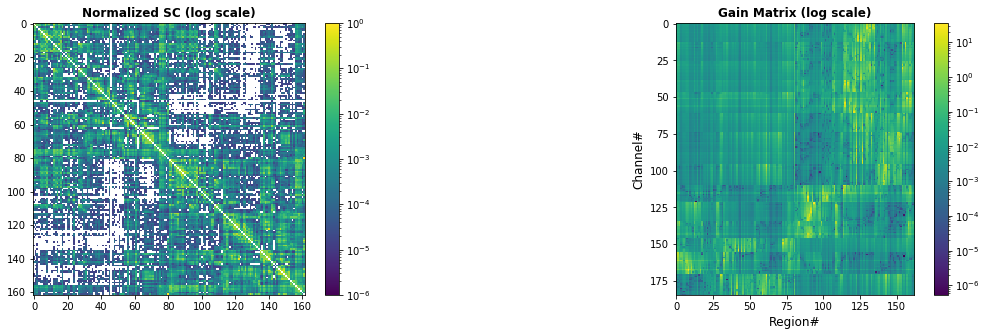

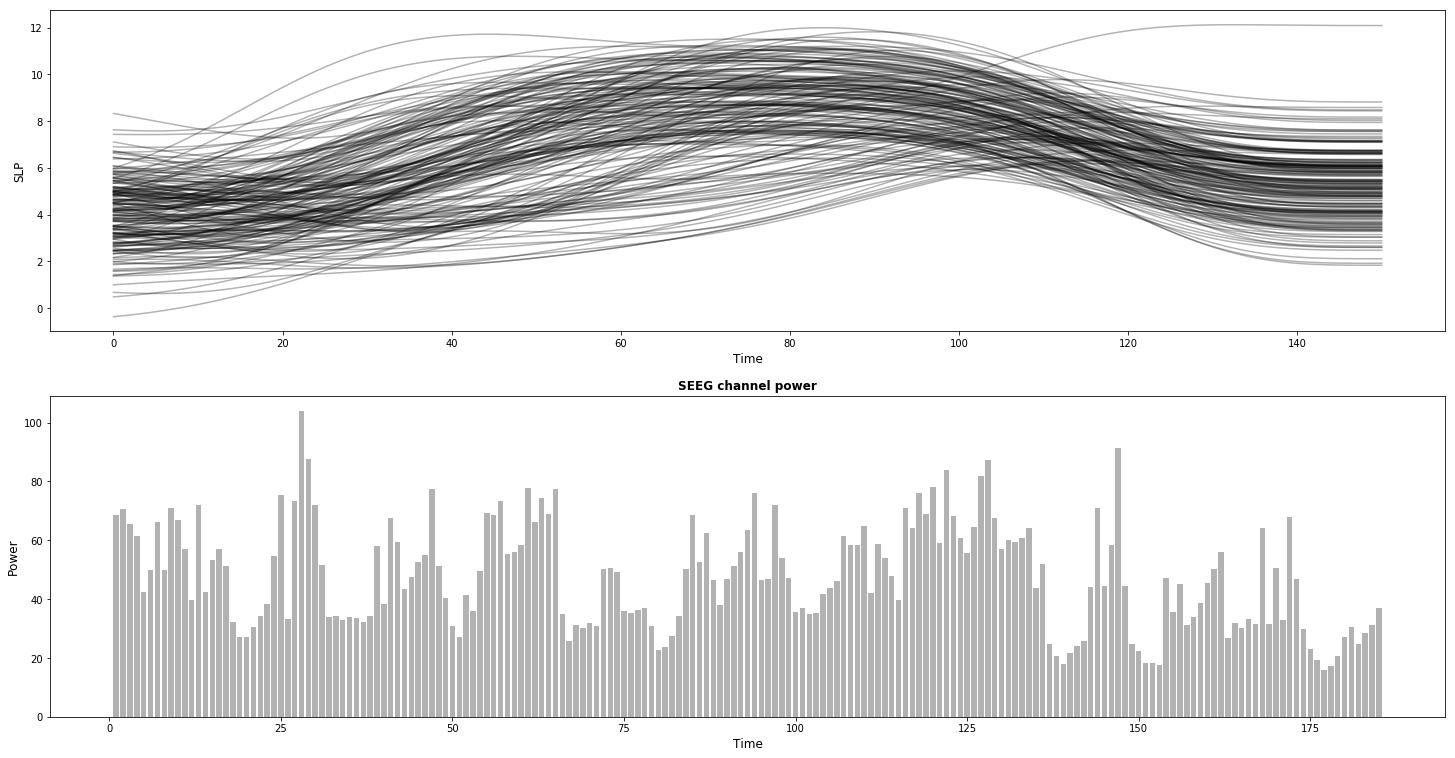

In [11]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(data['SC'],norm=matplotlib.colors.LogNorm(vmin=1e-6, vmax=data['SC'].max()));
plt.colorbar(fraction=0.046,pad=0.04);
plt.title('Normalized SC (log scale)',fontsize=12, fontweight='bold')

plt.subplot(122)
plt.imshow(data['gain'],norm=matplotlib.colors.LogNorm(vmin=data['gain'].min(), vmax=data['gain'].max()));
plt.colorbar(fraction=0.046,pad=0.04);
plt.xlabel('Region#', fontsize=12)
plt.ylabel('Channel#', fontsize=12)
plt.title('Gain Matrix (log scale)',fontsize=12, fontweight='bold')
plt.savefig(f'{results_dir}/figures/network.png')

plt.figure(figsize=(25,13))
plt.subplot(211)
plt.plot(data['slp'], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=12)
plt.ylabel('SLP', fontsize=12)

plt.subplot(212)
plt.bar(np.r_[1:data['ns']+1],data['snsr_pwr'], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.title('SEEG channel power', fontweight='bold')
plt.savefig(f'{results_dir}/figures/fitting_target_{fname_suffix}.png')
# plt.tight_layout()


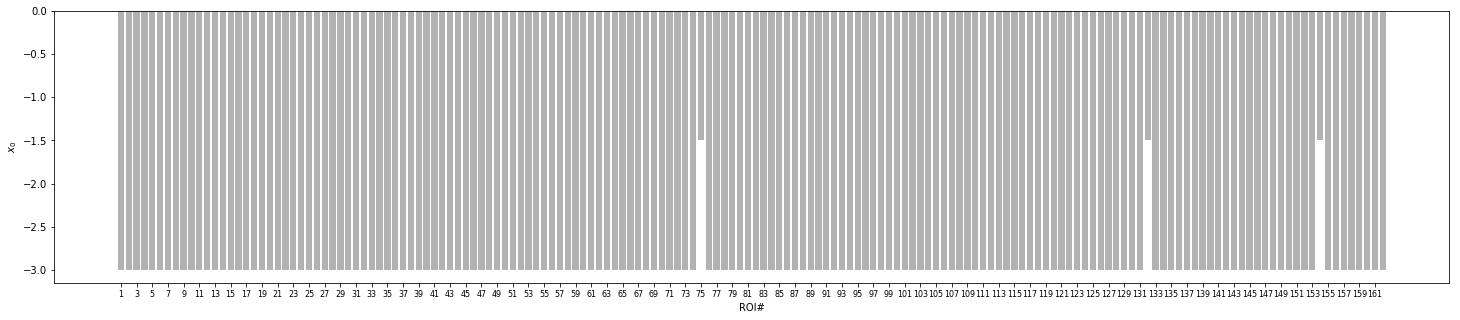

In [12]:
plt.figure(figsize=(25,5))
plt.bar(np.r_[1:data['nn']+1],data['x0_mu'], color='black', alpha=0.3)
plt.xticks(np.r_[1:data['nn']+1:2], fontsize=8);
plt.xlabel('ROI#')
plt.ylabel(r'$x_0$', fontsize=10)
plt.savefig(f'{results_dir}/figures/ez_hyp.png')

In [13]:
pstr_samples = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}_chain1.csv'])


chains = [1,2,3,4]
for i,chain_no in enumerate(chains):
    pstr_samples = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}_chain{chain_no}.csv'])

    print(pstr_samples['x0'],pstr_samples['tau0'])

#lib.plots.stan.x0_violin_patient(pstr_samples['x0'], ez_hyp, figsize=(30,5), figname=f'{results_dir}/figures/x0_violin_{fname_suffix}_chain{chain_no}.png')
figsize = [25,30]
x0_infer = pstr_samples['x0']
ns = x0_infer.shape[1]
plt.figure(figsize=figsize)
gs = gridspec.GridSpec(1,2,width_ratios = [1,8])

ax=plt.subplot(gs[0,0])
plt.barh(np.arange(0, ns), x0_infer[0][::-1]+5, color='black', alpha=0.3)
plt.yticks(np.r_[:len(roi)], roi[::-1]);

for ichanvep in ezh_all[patient_id]['i_ez']:
            plt.gca().get_yticklabels()[161-ichanvep].set_color('red')
for ichanvep in ezh_all[patient_id]['i_pz']:
            plt.gca().get_yticklabels()[161-ichanvep].set_color('blue')

plt.ylim([-2,ns])
ax2=plt.subplot(gs[0,1])
scaleplt=4
TimeSeries = pstr_samples['x'].mean(axis=0).T
TS = np.arange(np.shape(TimeSeries)[1])
for i in range(ns)[::-1]:
    plt.plot(TS, scaleplt*TimeSeries[i]/np.ptp(TimeSeries) + i, 'black', lw=0.4);
    if 161-i in ind_ez:
        plt.plot(TS, scaleplt*TimeSeries[i]/np.ptp(TimeSeries) + i, 'red', lw=0.6);
    if 161-i in ind_pz:
        plt.plot(TS, scaleplt*TimeSeries[i]/np.ptp(TimeSeries) + i, 'blue', lw=0.6);
plt.yticks(np.r_[:len(roi)], roi[::-1]);
for ichanvep in ind_ez:
            plt.gca().get_yticklabels()[161-ichanvep].set_color('red')
for ichanvep in ind_pz:
            plt.gca().get_yticklabels()[161-ichanvep].set_color('blue')


#plt.ylim([-2,ns])
plt.xlim([0,TS[-1]])
plt.tight_layout()


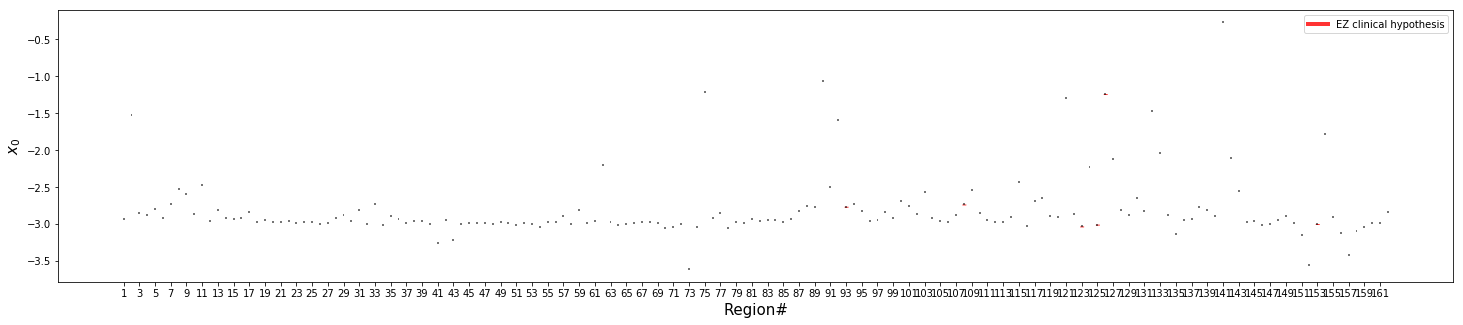

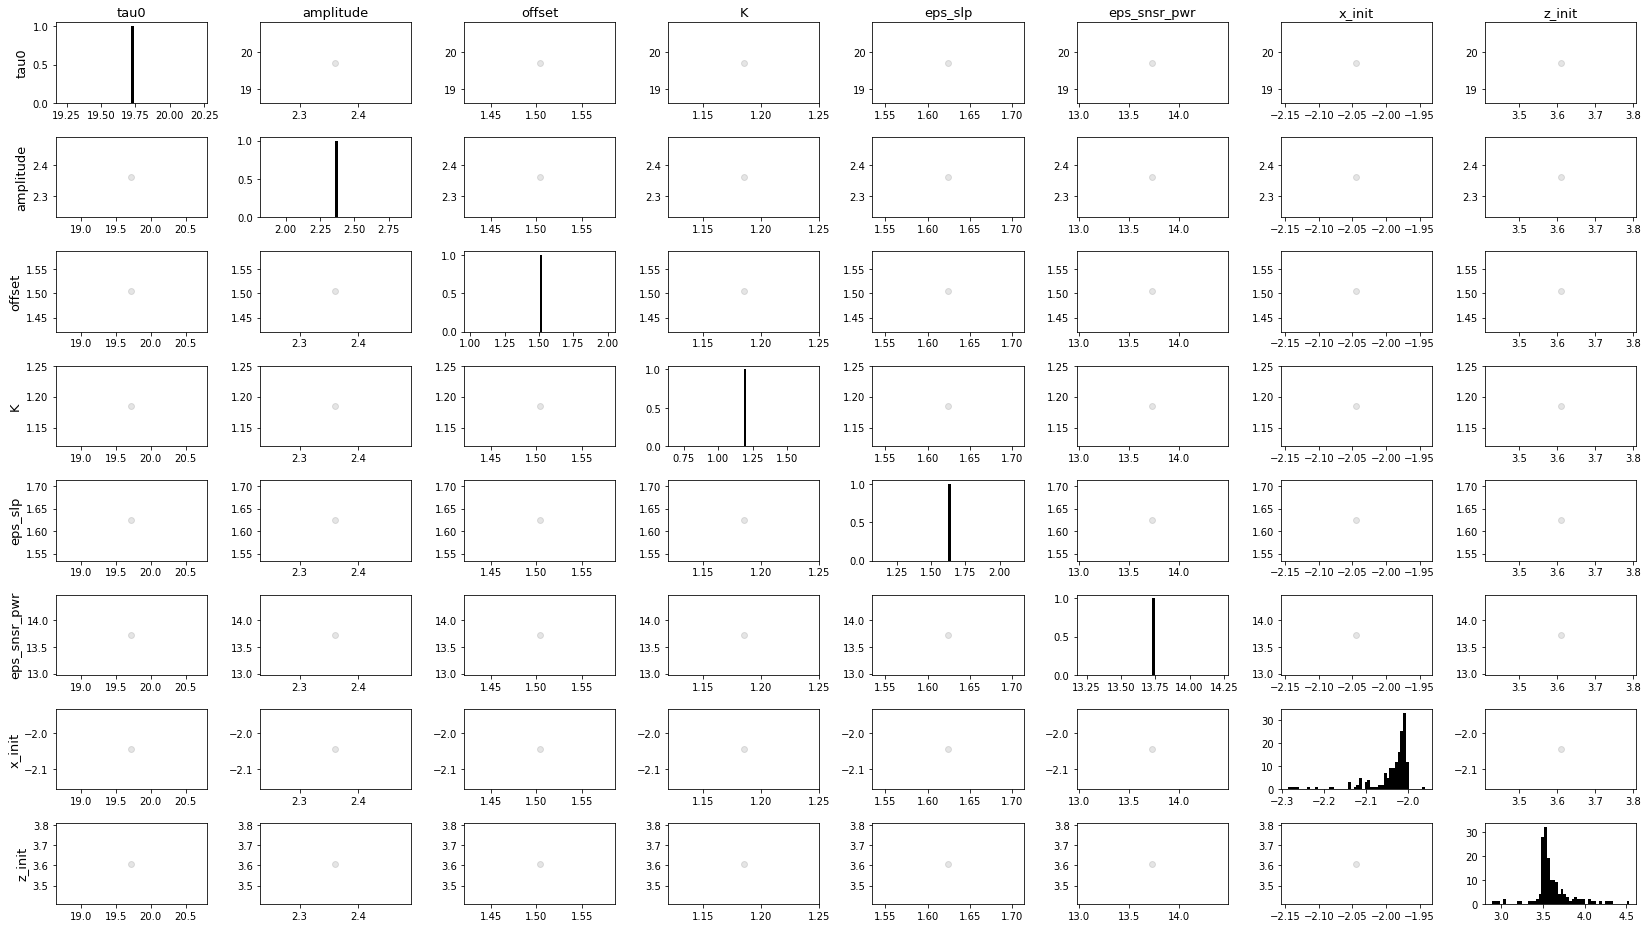

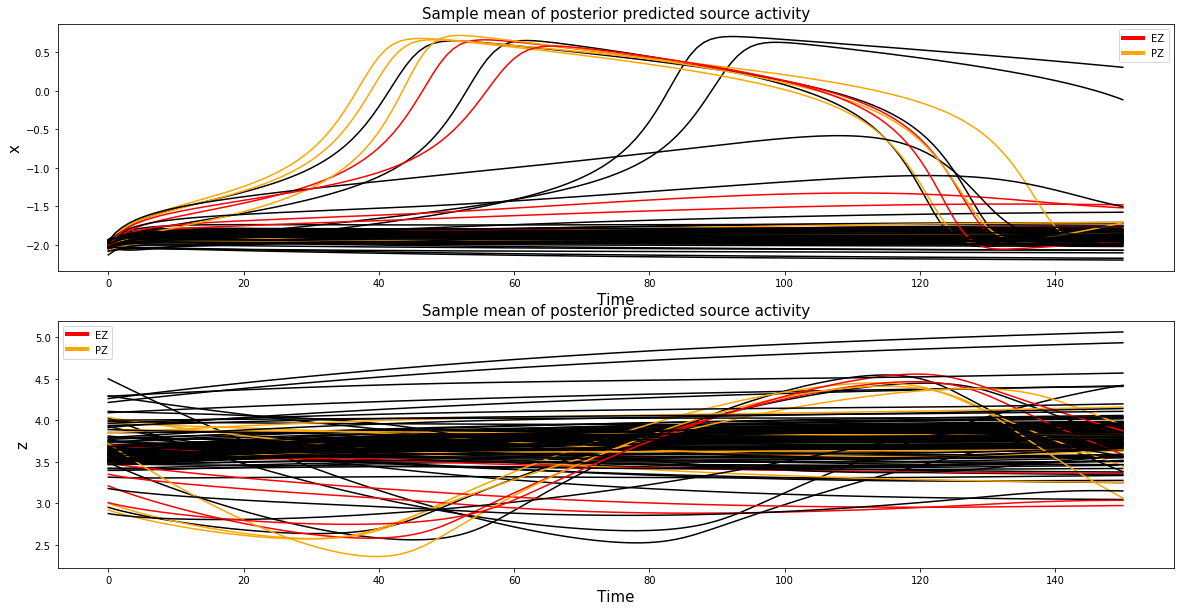

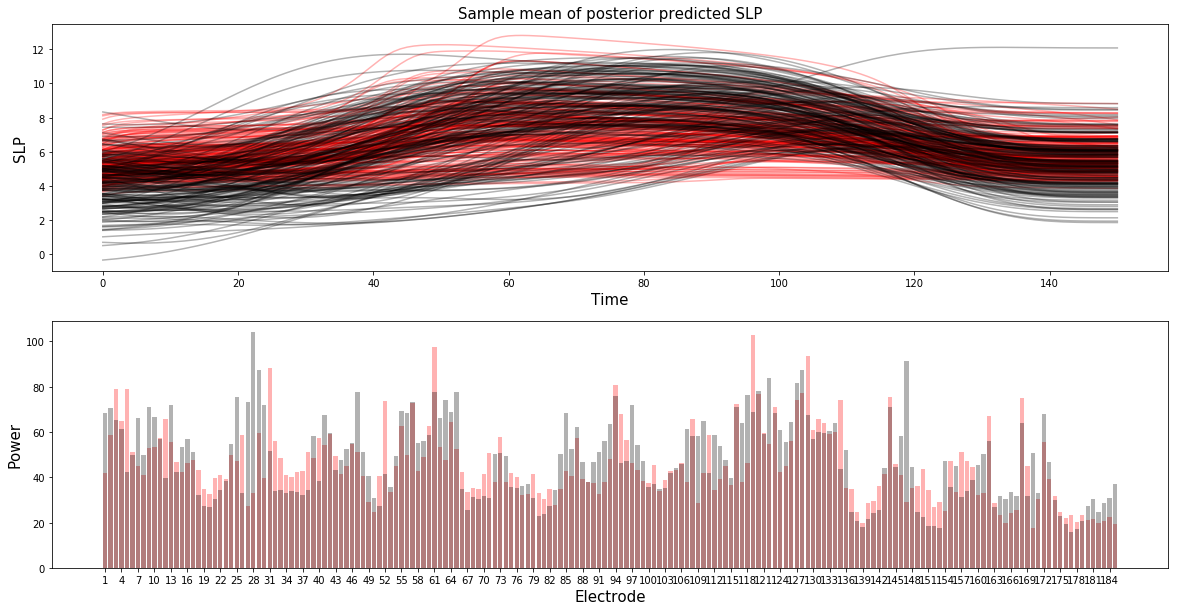

In [18]:
# import importlib
# importlib.reload(lib.plots.stan)

# ez_hyp = np.where(np.loadtxt(f'{data_dir}/tvb/ez_hypothesis.destrieux.txt') == 1)[0]


In [19]:
#a, b = np.histogram(onsets[onsets<150])

#ez_pred = np.zeros(nn)
#ez_pred[np.where(onsets<b[1])] = 1

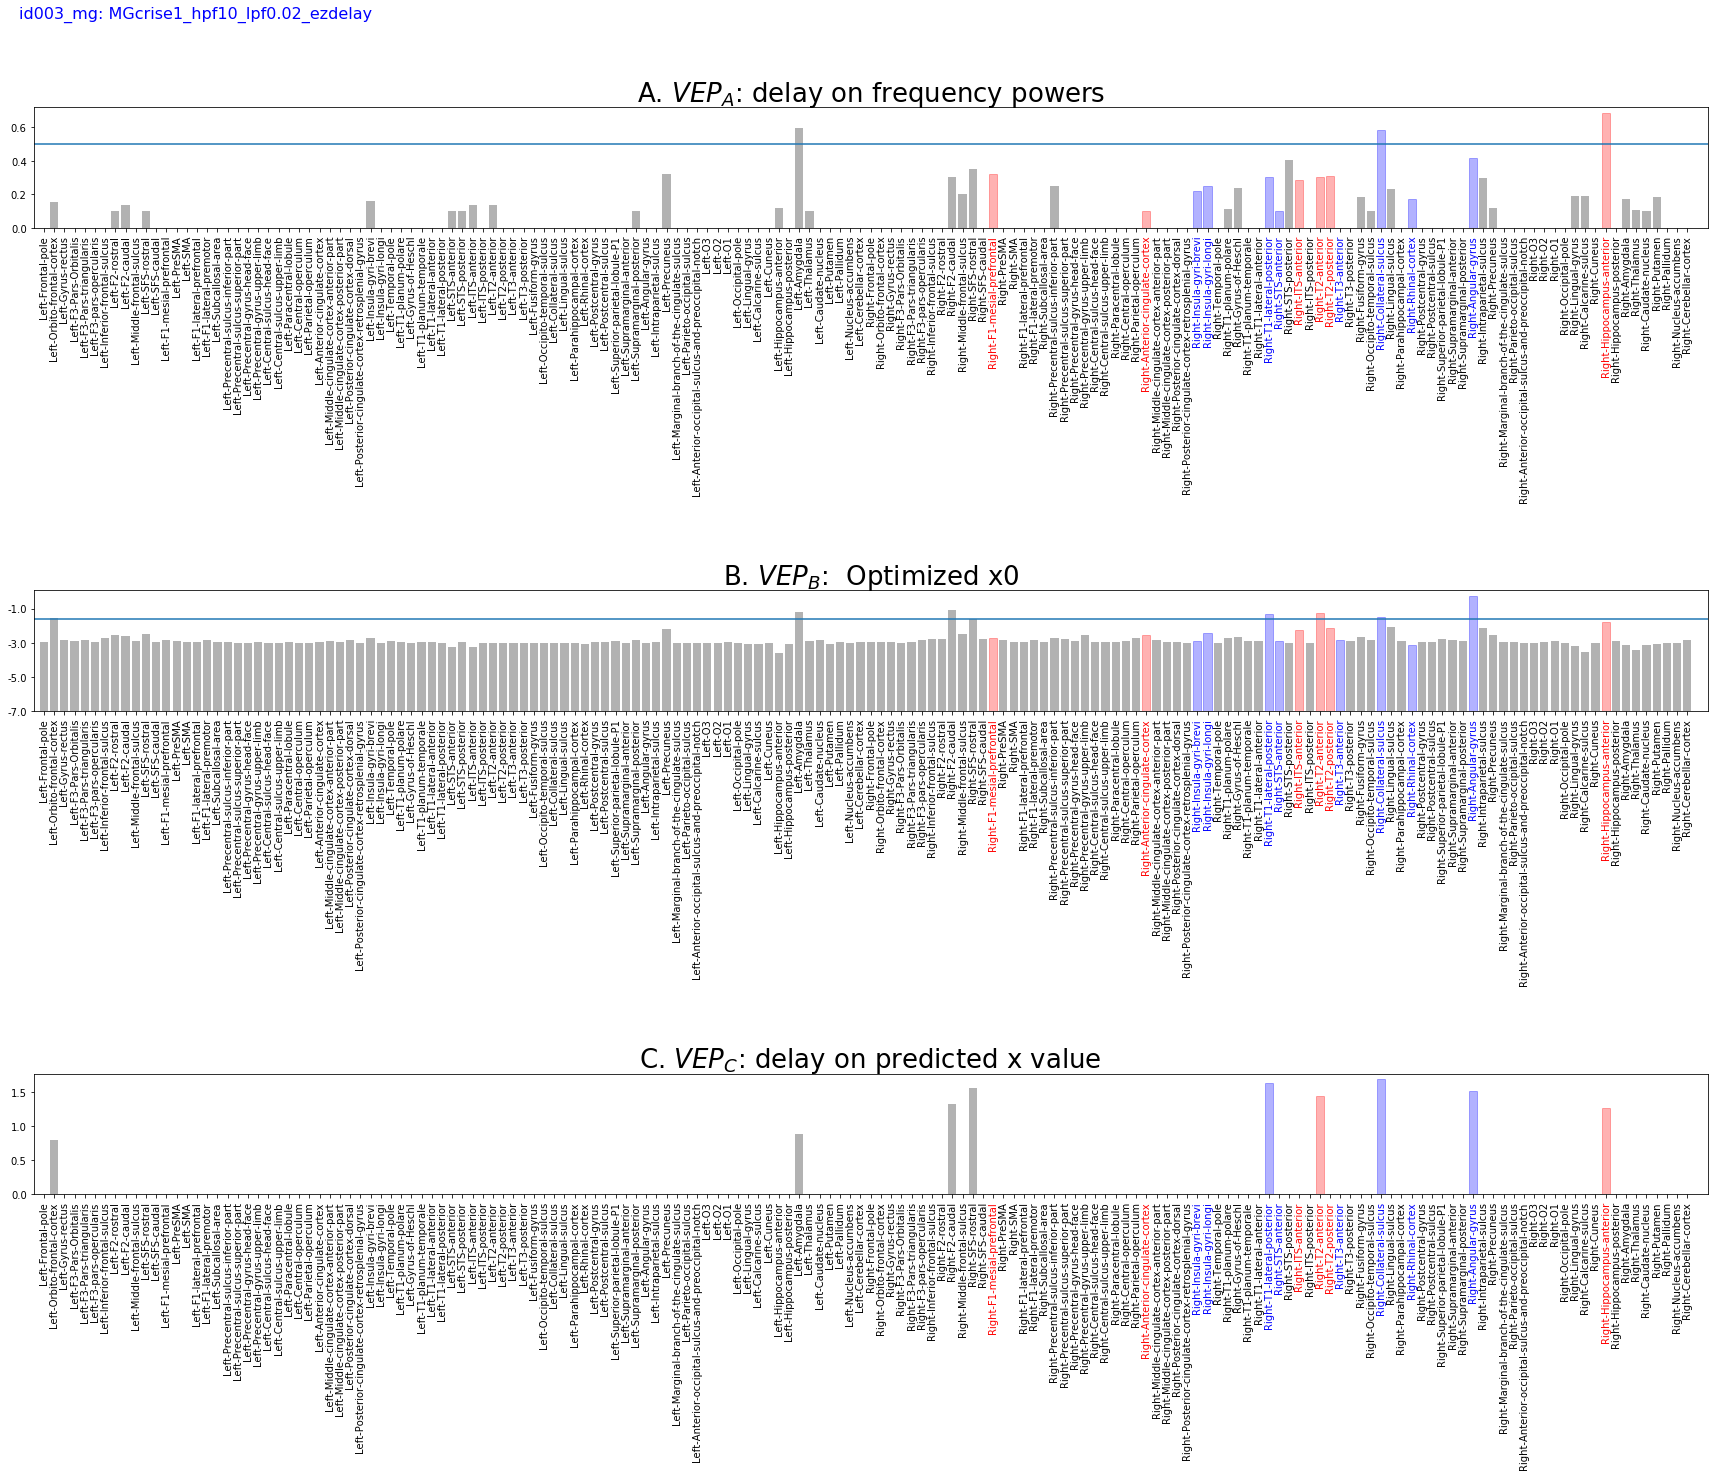

In [30]:
#lib.plots.stan.x0_violin_patient(pstr_samples['x0'], ez_hyp, figsize=(30,5), figname=f'{results_dir}/figures/x0_violin_{fname_suffix}_chain{chain_no}.png')
import matplotlib.gridspec as gridspec
pstr_samples = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}_chain1.csv'])
figsize = [30,20]
x0_infer = pstr_samples['x0']
ns = x0_infer.shape[1]
plt.figure(figsize=figsize)
gs = gridspec.GridSpec(3,1,hspace = 3)
#ax = plt.subplot(3,1,2)


#plt.figure(figsize=figsize)
#gs = gridspec.GridSpec(1,2,width_ratios = [1,8])

#ax = plt.subplot(3,1,1)
ax=plt.subplot(gs[0,0])
barlist=plt.bar(np.arange(0, ns), d0_prior, color='black', alpha=0.3)
plt.xticks(np.r_[:len(roi)], roi, rotation = 90);

for ichanvep in ezh_all[pid]['i_ez']:
    plt.gca().get_xticklabels()[ichanvep].set_color('red')
    barlist[ichanvep].set_color('r')
for ichanvep in ezh_all[pid]['i_pz']:
    plt.gca().get_xticklabels()[ichanvep].set_color('blue')
    barlist[ichanvep].set_color('blue')
plt.title('A. $VEP_A$: delay on frequency powers', fontsize = 26);
ax.axhline(0.5)
plt.xlim([-1,163])

ax=plt.subplot(gs[1,0])
barlist=plt.bar(np.arange(0, ns), x0_infer[0]+7, color='black', alpha=0.3)
plt.xticks(np.r_[:len(roi)], roi, rotation = 90);
ax.axhline(-1.6+7)
for ichanvep in ezh_all[pid]['i_ez']:
    plt.gca().get_xticklabels()[ichanvep].set_color('red')
    barlist[ichanvep].set_color('r')
for ichanvep in ezh_all[pid]['i_pz']:
    plt.gca().get_xticklabels()[ichanvep].set_color('blue')
    barlist[ichanvep].set_color('blue')
plt.title('B. $VEP_B$:  Optimized x0', fontsize = 26)       
plt.xlim([-1,163])
ax.set_yticklabels(item-7. for item in ax.get_yticks())


ax=plt.subplot(gs[2,0])
#ax = plt.subplot(3,1,3)
#plt.figure(figsize=figsize)
barlist=plt.bar(np.arange(0, ns), ez_pred, color='black', alpha=0.3)
plt.xticks(np.r_[:len(roi)], roi, rotation = 90);

for ichanvep in ezh_all[pid]['i_ez']:
    plt.gca().get_xticklabels()[ichanvep].set_color('red')
    barlist[ichanvep].set_color('r')
for ichanvep in ezh_all[pid]['i_pz']:
    plt.gca().get_xticklabels()[ichanvep].set_color('blue')
    barlist[ichanvep].set_color('blue')
plt.title('C. $VEP_C$: delay on predicted x value', fontsize = 26);
plt.xlim([-1,163])
figname=f'{results_dir}/figures/Vep3value_{fname_suffix}_chain{chain_no}.png'
plt.suptitle(f'{pid}: {fname_suffix}',x=0.2, y=.95, fontsize = 16, color='blue')
plt.savefig(figname)

A'5-6 :  Left-Amygdala
A'6-7 :  Left-Amygdala
A'7-8 :  Left-Amygdala
A'8-9 :  Left-Amygdala
TB'1-2 :  Left-Hippocampus-anterior
TB'2-3 :  Left-Hippocampus-anterior
TB'3-4 :  Left-Hippocampus-anterior
A'1-2 :  Left-Hippocampus-anterior
A'2-3 :  Left-Hippocampus-anterior
A'3-4 :  Left-Hippocampus-anterior
A'4-5 :  Left-Hippocampus-anterior
B'1-2 :  Left-Hippocampus-anterior
B'2-3 :  Left-Hippocampus-anterior
B'3-4 :  Left-Hippocampus-anterior
B'4-5 :  Left-Hippocampus-anterior
B'5-6 :  Left-Hippocampus-anterior
GPH'3-4 :  Left-Hippocampus-posterior
GPH'4-5 :  Left-Hippocampus-posterior
GPH'5-6 :  Left-Hippocampus-posterior


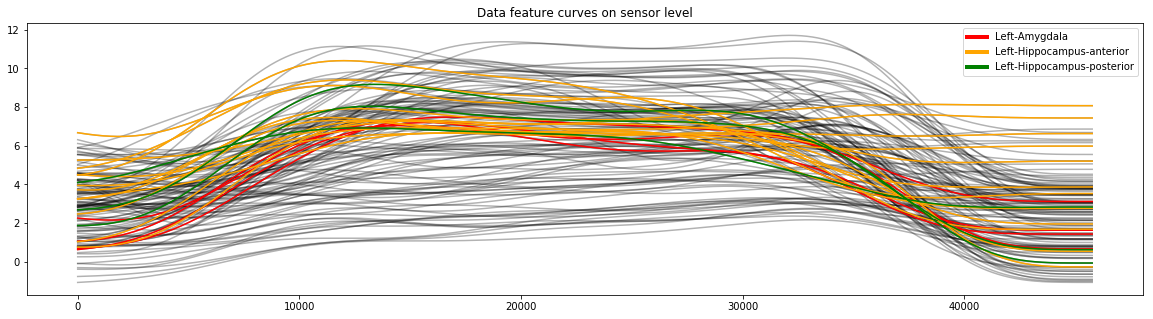

In [18]:
roi_sel=['Left-Amygdala','Left-Hippocampus-anterior','Left-Hippocampus-posterior']
color = ['red','orange','green','blue']
add='False Negative'
#roi_sel = ['Left-Hippocampus-posterior', 'Left-Hippocampus-anterior']
plt.figure(figsize=(20,5))
ns=162
vep_smax = np.zeros(ns)

legend_elements = []
for il, ilabel in enumerate(roi_sel):
    legend_elements.append(Line2D([0], [0], color=color[il], linewidth=4, label=ilabel))

plt.plot(slp, color='black', alpha=0.3);



for idroi, iroi in enumerate(roi_sel):
    ez_contacts_ = []

    for ibip_elec, indroi_iv in zip(bip.ch_names,np.argmax(data['gain'],axis=1)):
        if roi[indroi_iv]== iroi:
            print(ibip_elec, ': ', roi[indroi_iv])
            ez_contacts_.append(ibip_elec)
    m_ez = np.array([_ in ez_contacts_ for _ in bip.ch_names])
    
    plt.plot(slp[:,m_ez],color=legend_elements[idroi].get_color(),alpha = 1);
       

plt.legend(handles=legend_elements)
plt.title('Data feature curves on sensor level')
figname=f'{results_dir}/figures/fdfc_A_{fname_suffix}_{add}.png'
plt.savefig(figname)
#plt.xticks(np.r_[:len(roi)], roi, rotation = 90);
#plt.axvline(base_length)
#plt.axvline(len(slp)-base_length)

A'5-6 :  Left-Amygdala
A'6-7 :  Left-Amygdala
A'7-8 :  Left-Amygdala
A'8-9 :  Left-Amygdala
TB'1-2 :  Left-Hippocampus-anterior
TB'2-3 :  Left-Hippocampus-anterior
TB'3-4 :  Left-Hippocampus-anterior
A'1-2 :  Left-Hippocampus-anterior
A'2-3 :  Left-Hippocampus-anterior
A'3-4 :  Left-Hippocampus-anterior
A'4-5 :  Left-Hippocampus-anterior
B'1-2 :  Left-Hippocampus-anterior
B'2-3 :  Left-Hippocampus-anterior
B'3-4 :  Left-Hippocampus-anterior
B'4-5 :  Left-Hippocampus-anterior
B'5-6 :  Left-Hippocampus-anterior
GPH'3-4 :  Left-Hippocampus-posterior
GPH'4-5 :  Left-Hippocampus-posterior
GPH'5-6 :  Left-Hippocampus-posterior


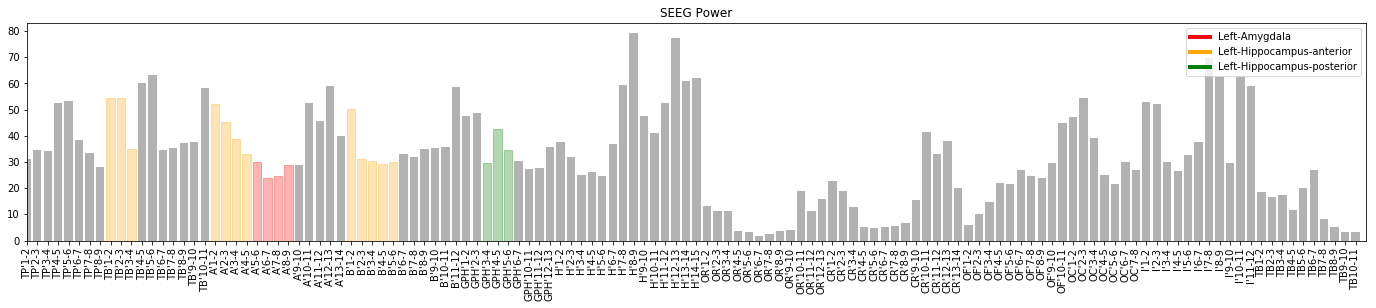

In [19]:
#roi_sel = ['Left-Hippocampus-posterior', 'Left-Hippocampus-anterior']
#roi_sel=['Left-SFS-caudal']
#add='left-SFS-caudal'
plt.figure(figsize=(24,4))

power=(data['slp']**2).mean(axis=0)
barlist=plt.bar(np.arange(0, len(power)), power, color='black', alpha=0.3)
plt.xticks(np.r_[:len(bip.ch_names)], bip.ch_names, rotation = 90);

for idroi, iroi in enumerate(roi_sel):
    ez_contacts_ = []

    for ibip_elec, indroi_iv in zip(bip.ch_names,np.argmax(data['gain'],axis=1)):
        if roi[indroi_iv]== iroi:
            print(ibip_elec, ': ', roi[indroi_iv])
            ez_contacts_.append(ibip_elec)
    m_ez = np.array([_ in ez_contacts_ for _ in bip.ch_names])
    
    
    for ichanvep in np.where(m_ez == True)[0]:
        barlist[ichanvep].set_color(legend_elements[idroi].get_color())
#plt.plot(slp[:,m_ez],color=legend_elements[idroi].get_color(),alpha = 1);
plt.title('SEEG Power')
plt.legend(handles=legend_elements)  
plt.xlim([0,len(bip.ch_names)])
figname=f'{results_dir}/figures/fdfc_C_{fname_suffix}_{add}.png'
plt.savefig(figname)
#plt.gca().get_xticklabels()[m_ez].set_color(legend_elements[idroi].get_color())
 

A'5-6 :  Left-Amygdala
A'6-7 :  Left-Amygdala
A'7-8 :  Left-Amygdala
A'8-9 :  Left-Amygdala
TB'1-2 :  Left-Hippocampus-anterior
TB'2-3 :  Left-Hippocampus-anterior
TB'3-4 :  Left-Hippocampus-anterior
A'1-2 :  Left-Hippocampus-anterior
A'2-3 :  Left-Hippocampus-anterior
A'3-4 :  Left-Hippocampus-anterior
A'4-5 :  Left-Hippocampus-anterior
B'1-2 :  Left-Hippocampus-anterior
B'2-3 :  Left-Hippocampus-anterior
B'3-4 :  Left-Hippocampus-anterior
B'4-5 :  Left-Hippocampus-anterior
B'5-6 :  Left-Hippocampus-anterior
GPH'3-4 :  Left-Hippocampus-posterior
GPH'4-5 :  Left-Hippocampus-posterior
GPH'5-6 :  Left-Hippocampus-posterior


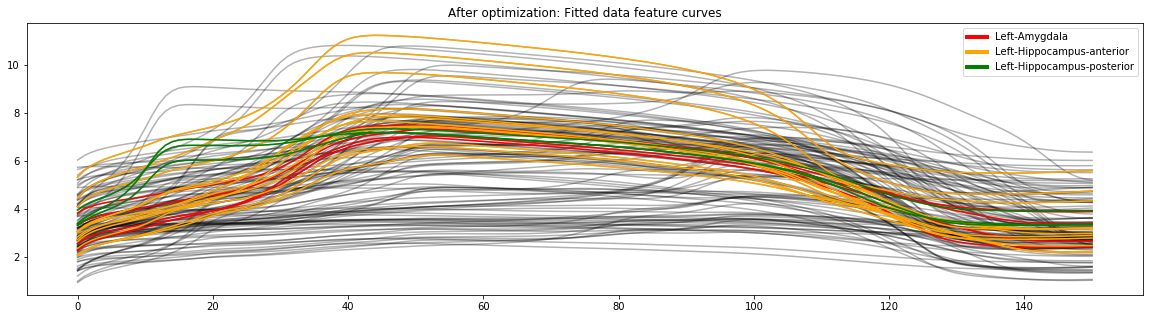

In [20]:
plt.figure(figsize=(20,5))
ns=162
vep_smax = np.zeros(ns)

mu_slp=pstr_samples['mu_slp'].mean(axis=0)



plt.plot(mu_slp, color='black', alpha=0.3);



for idroi, iroi in enumerate(roi_sel):
    ez_contacts_ = []

    for ibip_elec, indroi_iv in zip(bip.ch_names,np.argmax(data['gain'],axis=1)):
        if roi[indroi_iv]== iroi:
            print(ibip_elec, ': ', roi[indroi_iv])
            ez_contacts_.append(ibip_elec)
    m_ez = np.array([_ in ez_contacts_ for _ in bip.ch_names])
    
    plt.plot(mu_slp[:,m_ez],color=legend_elements[idroi].get_color(),alpha = 1);
       

plt.legend(handles=legend_elements)
plt.title('After optimization: Fitted data feature curves')
figname=f'{results_dir}/figures/fdfc_B_{fname_suffix}_{add}.png'
plt.savefig(figname)

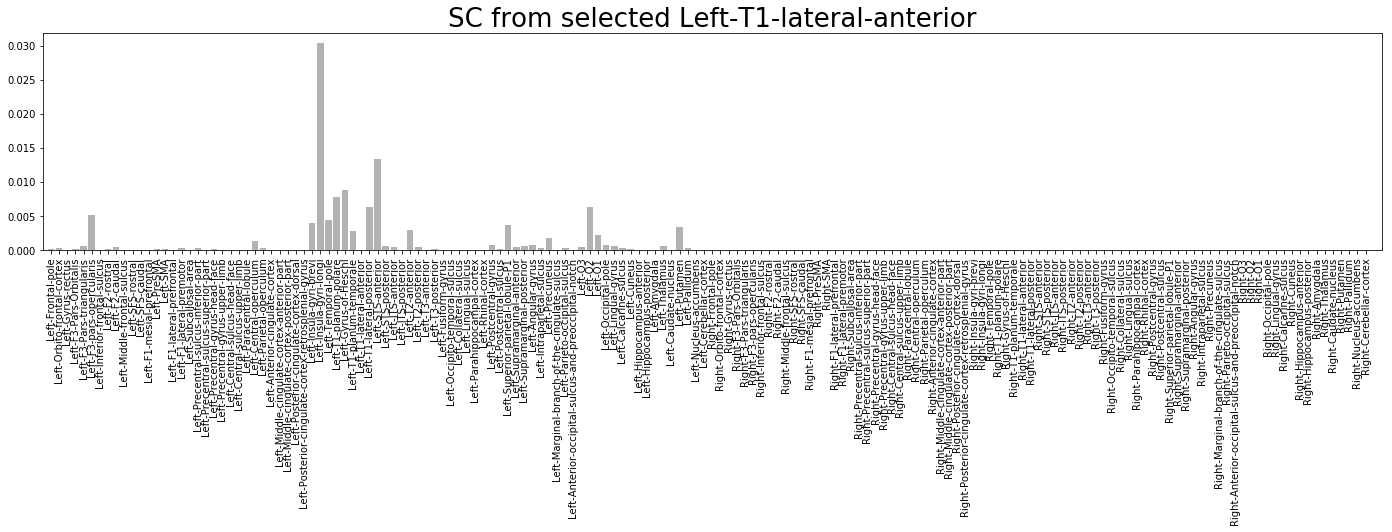

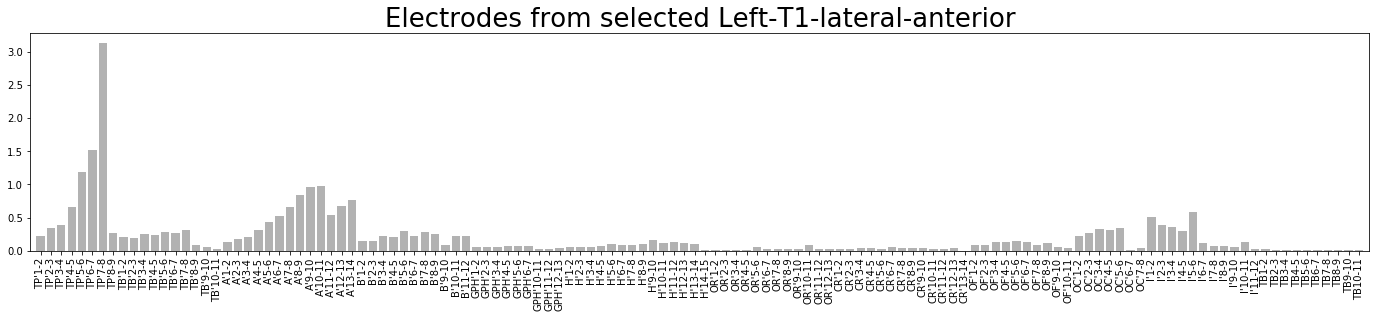

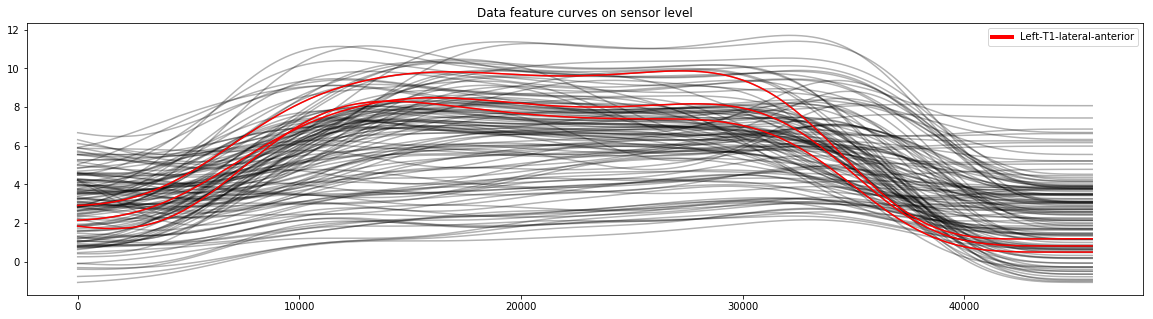

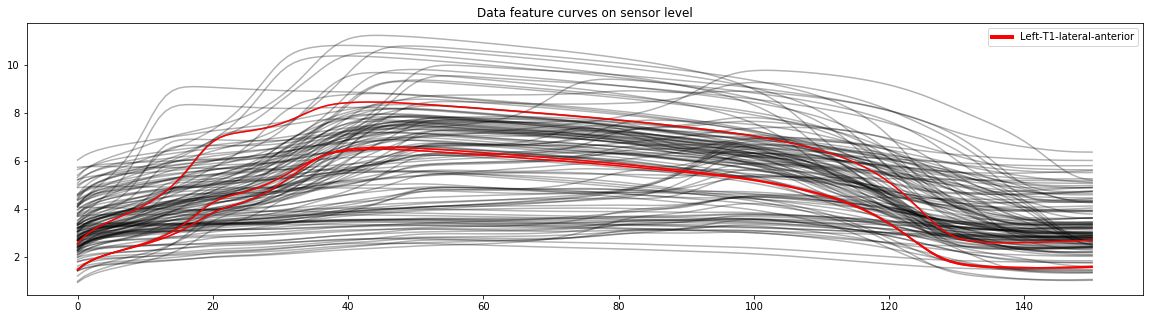

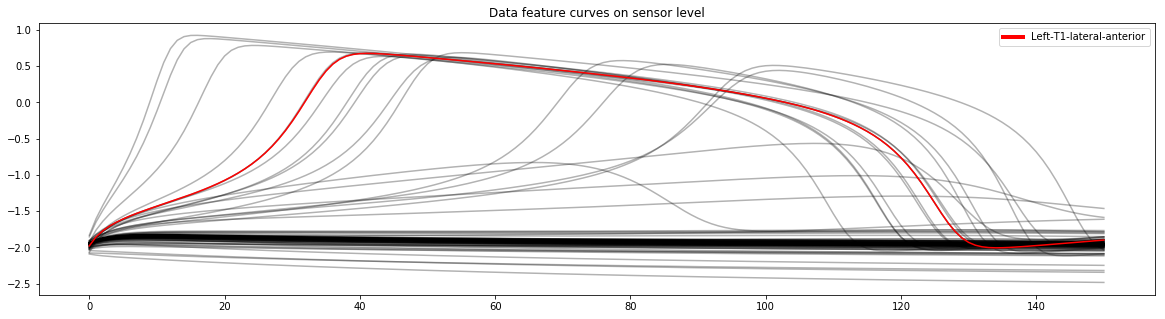

In [23]:
#roi_given = 'Left-SFS-caudal'
roi_given = 'Left-T1-lateral-anterior'
plt.figure(figsize=(24,4))
barlist=plt.bar(np.arange(0, ns), data['SC'][roi.index(roi_given)], color='black', alpha=0.3)
plt.xticks(np.r_[:len(roi)], roi, rotation = 90);
plt.title(f'SC from selected {roi_given}', fontsize = 26);
plt.xlim([-1,163])

plt.figure(figsize=(24,4))
barlist=plt.bar(np.arange(0, len(bip.ch_names)), data['gain'].T[roi.index(roi_given)], color='black', alpha=0.3)
plt.xticks(np.r_[:len(bip.ch_names)], bip.ch_names, rotation = 90);
plt.title(f'Electrodes from selected {roi_given}', fontsize = 26);
plt.xlim([-1,len(bip.ch_names)])

gain_roi_given=data['gain'].T[roi.index(roi_given)]

plt.figure(figsize=(20,5))
ns=162
vep_smax = np.zeros(ns)


plt.plot(slp, color='black', alpha=0.3);

#plt.plot(slp[:,np.argmax(gain_roi_given)],color='red',alpha = 1);
plt.plot(slp[:,np.where(gain_roi_given>1)[0]],color='red',alpha = 1)

plt.legend(handles=legend_elements)
plt.title('Data feature curves on sensor level')
figname=f'{results_dir}/figures/fdfc_A_{fname_suffix}_{add}.png'
plt.savefig(figname)



plt.figure(figsize=(20,5))
ns=162
legend_elements = []
for il, ilabel in enumerate([roi_given]):
    legend_elements.append(Line2D([0], [0], color=color[il], linewidth=4, label=ilabel))
vep_smax = np.zeros(ns)
add='FP'
plt.plot(mu_slp, color='black', alpha=0.3);

plt.plot(mu_slp[:,np.where(gain_roi_given>1)[0]],color='red',alpha = 1);


plt.legend(handles=legend_elements)
plt.title('Data feature curves on sensor level')
figname=f'{results_dir}/figures/fdfc_A_{fname_suffix}_{add}.png'
plt.savefig(figname)

plt.figure(figsize=(20,5))
ns=162
vep_smax = np.zeros(ns)




plt.plot(pstr_samples['x'].mean(axis=0), color='black', alpha=0.3);

plt.plot(pstr_samples['x'].mean(axis=0)[:,roi.index(roi_given)],color='red',alpha = 1);


plt.legend(handles=legend_elements)
plt.title('Data feature curves on sensor level')
figname=f'{results_dir}/figures/fdfc_A_{fname_suffix}_{add}.png'
plt.savefig(figname)

In [ ]:
plt.figure(figsize=(20,5))
ns=162
vep_smax = np.zeros(ns)




plt.plot(pstr_samples['x'].mean(axis=0), color='black', alpha=0.3);

plt.plot(pstr_samples['x'].mean(axis=0)[:,np.where(ez_pred>1)[0]],color='red',alpha = 1);


plt.legend(handles=legend_elements)
plt.title('Data feature curves on sensor level')
figname=f'{results_dir}/figures/fdfc_A_{fname_suffix}_{add}.png'
plt.savefig(figname)